In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
from keras.applications.resnet import ResNet50
import os
import cv2
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import numpy as np


def plot_confusion_mat(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [10]:
zip_file = "/content/cleaned_dataset.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [11]:
data_dir = '/content/cleaned_dataset/Training'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))

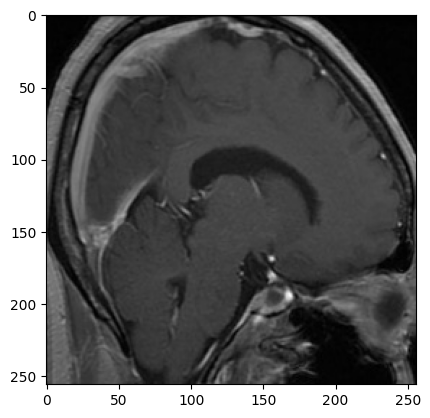

In [12]:
plt.imshow(img_array);

In [13]:
img_array.shape

(256, 256, 3)

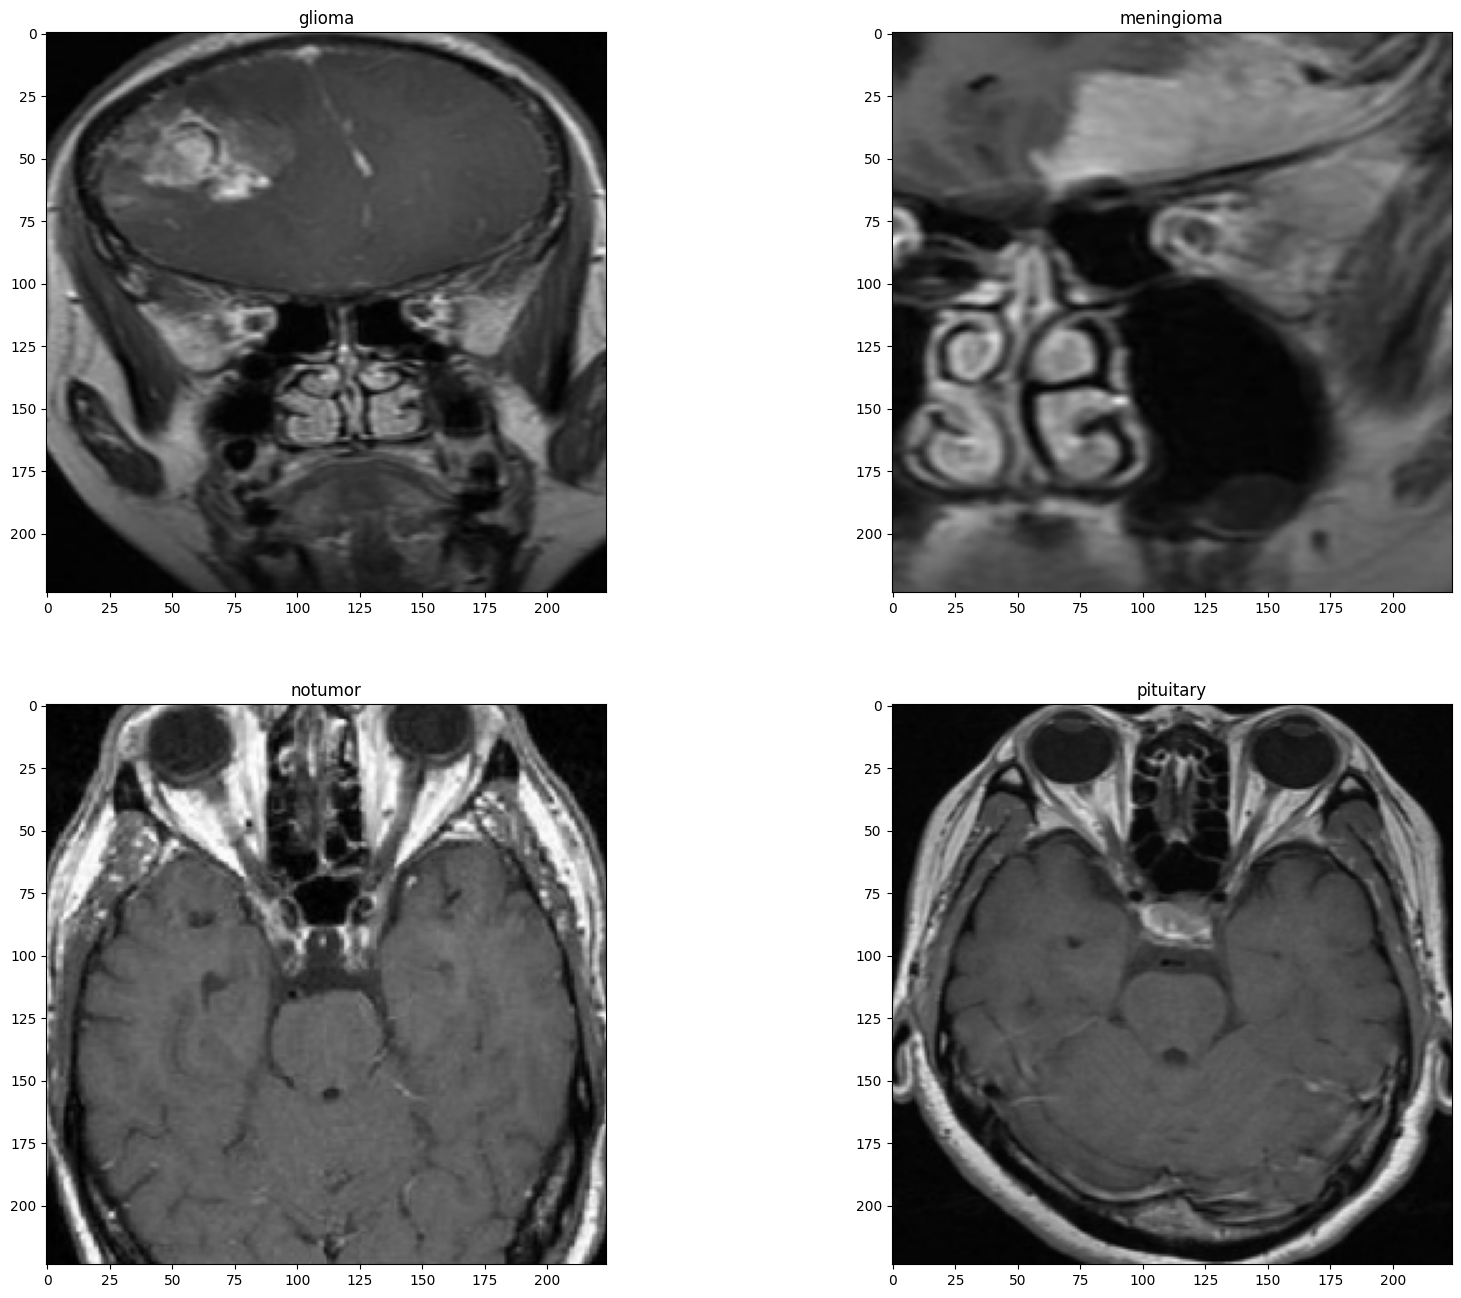

In [14]:
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-glTr_0000.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])

In [16]:
generator_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

generator_test = ImageDataGenerator(rescale=1./255)

train = generator_train.flow_from_directory(
    '/content/cleaned_dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb'
)

test = generator_test.flow_from_directory(
    '/content/cleaned_dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


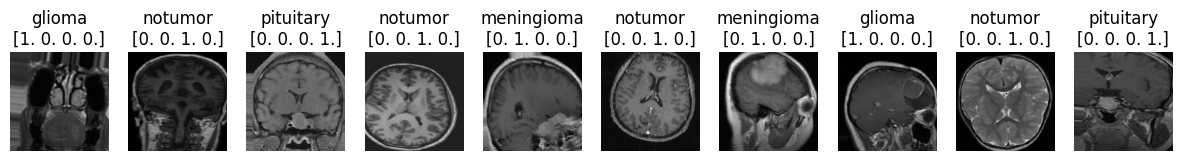

In [17]:
def plot_images_with_labels_and_vectors(generator, num_images=10):

    for images, labels in generator:
        plt.figure(figsize=(15, 15))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.axis('off')

            plt.imshow(images[i])

            label_vector = labels[i]
            label_name = None
            if generator.class_mode == "categorical":
                label_index = label_vector.argmax()
                label_name = list(generator.class_indices.keys())[label_index]
            plt.title(f"{label_name}\n{str(label_vector)}")

        plt.show()
        break
plot_images_with_labels_and_vectors(train, num_images=10)


In [18]:
NUM_CLASSES = 4
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(64,(7,7), input_shape=(224, 224, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Full connect layers

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))



optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     401536    
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                                                        

In [20]:
model_es = EarlyStopping(monitor='val_loss', min_delta=1e-11, patience=12, verbose=1)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1)
model_mcp = ModelCheckpoint(filepath='/content/cleaned_dataset/CNN_model_weights.h5', monitor='val_categorical_accuracy',
                            save_best_only=True, verbose=1)

steps_per_epoch = 5712 // 32
validation_steps = 1311 // 32

# Training the model
history = model.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=test,
    validation_steps=validation_steps,
    callbacks=[model_es, model_rlr, model_mcp]
)

178/178 [==============================] - ETA: 0s - loss: 0.4455 - categorical_accuracy: 0.8327
Epoch 5: val_categorical_accuracy did not improve from 0.60938
178/178 [==============================] - 93s 523ms/step - loss: 0.4455 - categorical_accuracy: 0.8327 - val_loss: 1.8968 - val_categorical_accuracy: 0.4602 - lr: 0.0010
Epoch 6/30
178/178 [==============================] - ETA: 0s - loss: 0.3895 - categorical_accuracy: 0.8637
Epoch 6: val_categorical_accuracy did not improve from 0.60938
178/178 [==============================] - 93s 523ms/step - loss: 0.3895 - categorical_accuracy: 0.8637 - val_loss: 1.5742 - val_categorical_accuracy: 0.5430 - lr: 0.0010
Epoch 7/30
178/178 [==============================] - ETA: 0s - loss: 0.3572 - categorical_accuracy: 0.8724
Epoch 7: val_categorical_accuracy improved from 0.60938 to 0.68437, saving model to /content/cleaned_dataset/CNN_model_weights.h5
178/178 [==============================] - 93s 520ms/step - loss: 0.3572 - categorical_ac

In [21]:
model.evaluate(test)

41/41 [==============================] - 6s 145ms/step - loss: 0.0672 - categorical_accuracy: 0.9809


[0.06717303395271301, 0.9809305667877197]

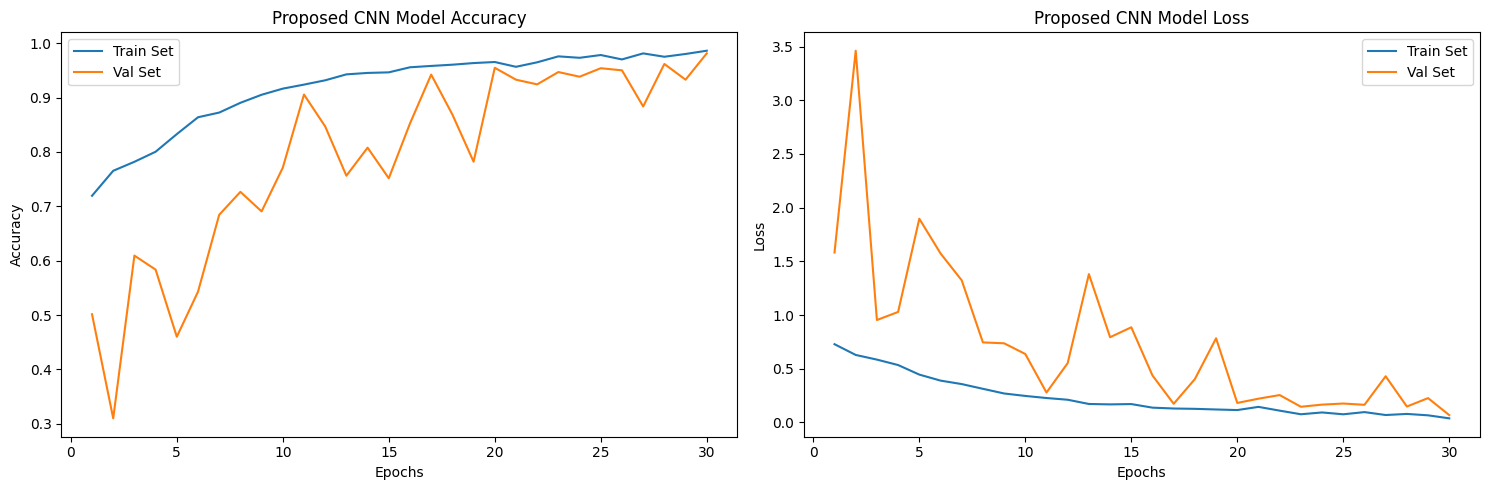

In [22]:
# plot proposed CNN model performance
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Proposed CNN Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Proposed CNN Model Loss')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 41ms/step
Val Accuracy = 0.97
[[7 0 0 0]
 [0 8 1 0]
 [0 0 9 0]
 [0 0 0 7]]


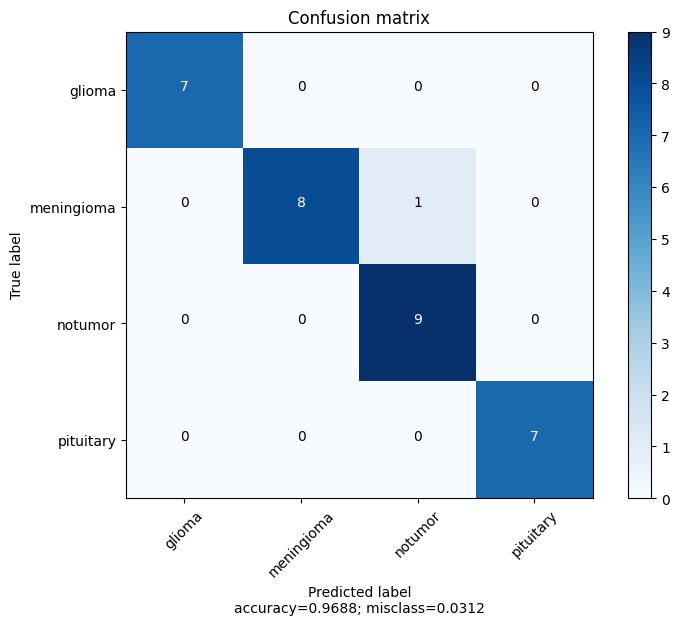

In [28]:
# validate on test set
import numpy as np
# for i in range(0,50):
X_test, y_test = next(test)
predictions = model.predict(X_test)
y_test = np.argmax(y_test,axis=1)
pred = np.argmax(predictions,axis=1)

accuracy = accuracy_score(y_test, pred)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, pred)
print(confusion_mtx)
plot_confusion_mat(confusion_mtx,['glioma', 'meningioma', 'notumor', 'pituitary'], normalize=False )